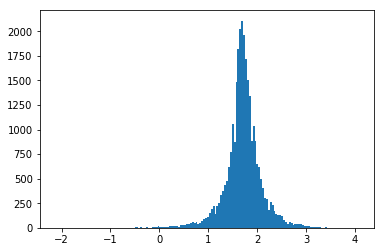

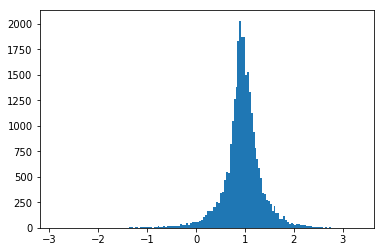

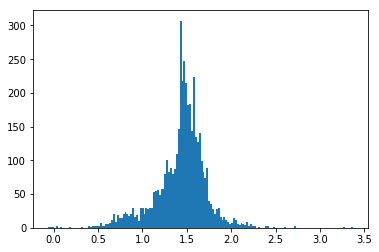

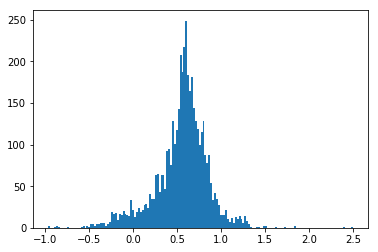

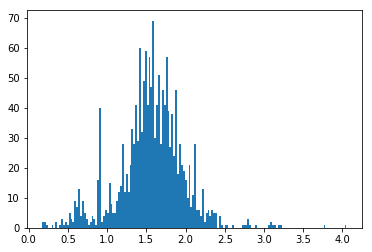

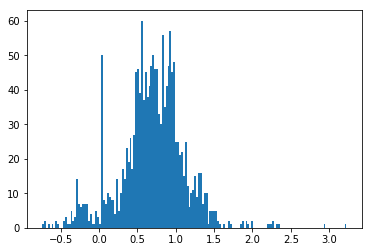

In [37]:
#coding:utf8
import os
import sys
from PIL import Image
import torch as t
from torch.utils import data
import numpy as np
from torchvision import transforms as T
sys.path.append('../') # base_root
from utils.data_util import *
from matplotlib import pyplot as plt
%matplotlib inline

class Kitti(data.Dataset):    
    def __init__(self,root='/hdd/you/rgbd-det/',
             white_list=[ 'Car', 'Pedestrian', 'Cyclist'],sets_type='train',process='train'):
        '''
        obj_type:all\car\cyc\ped
        sets_type:train\trainval\val\test for dataset
        process:train\val\test\ for train val or inference (no influence actually)
        root = '/hdd/you/rgbd-det/'
        '''
        idx_path = os.path.join(root, 'data/image_sets/{}.txt'.format(sets_type)) # 3types
        if sets_type is not 'test': sets_type = 'trainval' # all train & val in here 2 types
        # full_img_dir = os.path.join(root, 'dataset/{}/image_2'.format(sets_type)) # full image
        rgb_dir = os.path.join(root, 'dataset/{}/rgb'.format(sets_type)) # crop image
        depth_dir = os.path.join(root, 'dataset/{}/depth'.format(sets_type)) # crop depth image
        if sets_type is not 'test': # label or detection result
            sets_type = 'trainval/label'
        else:
            sets_type = 'test/det'
        text_path = os.path.join(root, 'dataset/{}'.format(sets_type))

        idx_fig = open(idx_path, 'r')
        idx_file = idx_fig.readlines()
        idx_fig.close()
        
        self.obj_types = {'Car':'0', 'Pedestrian':'1', 'Cyclist':'2'}
        outcasts = [] # path
        rgbs = [] # path 
        depths = []
        labels = [] # value; return img id when testing

        for idx in idx_file:
            idx = idx.strip('\n\r')
            txt = open(os.path.join(text_path,idx+'.txt'),'r')
            lines = txt.readlines()
            txt.close()
            for num,line in enumerate(lines):
                label = {} # init every time
                line = line.strip('\n\r').split(' ')
                obj_type = line[0]
                if obj_type not in white_list:
                    continue
                    
                lib = [obj_type] + list(map(float, line[1:]))
                obj = self.obj_types[obj_type]
                target = '{}.{}.{}.png'.format(idx,num,obj)
                
                if (lib[6]-lib[4])<=8 or (lib[7]-lib[5])<=8: # bad data
                    outcasts.append(os.path.join(rgb_dir, target))
                    continue
                    
                rgbs.append(os.path.join(rgb_dir, target))
                depths.append(os.path.join(depth_dir, target))
                #　full_img = Image.open(os.path.join(full_img_dir,idx+'.png')) # for img size norm
                # width, height = full_img.size[0] , full_img.size[1] # for img size norm
                # label['2d'] = [lib[4]/width, lib[5]/height, lib[6]/width, lib[7]/height] # for adding vector
                label['file'] = idx
                label['type'] = obj_type
                label['2d'] = [lib[4],lib[5],lib[6],lib[7]]
                if sets_type is not 'test':
                    label['loc'] = [lib[11], lib[12], lib[13]]
                    label['hwl'] = [lib[8], lib[9], lib[10]] # for iou
                    label['ry'] = lib[14]
                else:
                    label['loc'] = list(map(float, [idx, num, obj])) # return img ID when testing for wt res
                    label['hwl'] = [-1000, -1000, -1000] # for iou
                    label['ry'] = [-10] # for getting a value
                labels.append(label)
                
        self.idx_path = idx_path # 数据集索引文件
        self.rgb_dir = rgb_dir # 图片目录
        self.depth_dir = depth_dir # 深度图目录
        self.text_path = text_path # label目录、2D检测结果目录
        self.rgbs = rgbs # necessary 图片路径列表
        self.depths = depths # necessary 深度图路径列表
        self.labels = labels # necessary 标签具体数值
        self.outcasts = outcasts # 不满足要求的图片路径（尺寸过小）
        self.process = process # 指示当前是训练、验证、还是测试（当前并不影响具体代码）
    
    def __len__(self):
        return len(self.rgbs)
        # return 4
    
def draw_hist(white_list=[ 'Car', 'Pedestrian', 'Cyclist'],log=False):
    train_data = Kitti('/hdd/you/rgbd-det/',sets_type='trainval',process='train',white_list=white_list) 
    hc_all = []
    hc_all_t = []
    if log:
        num = 30
    else:
        num = len(train_data.labels)
    for i in range(num):
        label = train_data.labels[i]
        loc = label['loc']
        hwl = label['hwl']
        hc = loc[1] # +hwl[0]/2 # height of kitti car    x:+-20 y:0-3 z:0-80
        hc_all.append(hc)
        hc_t = loc[1] - hwl[0]/2 # center
        hc_all_t.append(hc_t)
        if log:
            print('file:',label['file'],'type:',label['type'],'loc:',loc,'hwl',hwl,'hc',hc)
    fig = plt.figure(1)
    plt.hist(hc_all, bins=160)
    fig2 = plt.figure(2)
    plt.hist(hc_all_t, bins=160)
    plt.show()
    

if __name__ == '__main__':
    draw_hist(['Car'])
    draw_hist(['Pedestrian'])
    draw_hist(['Cyclist'])